In [1]:
# coding: UTF-8
import os
import torch
import numpy as np
import pickle as pkl
from tqdm import tqdm
import time
from datetime import timedelta
import time
import torch
import numpy as np
from train_eval import train, init_network
from importlib import import_module
import argparse
import random
dataset = 'Newtrain_qinggan'  # 数据集

# 搜狗新闻:embedding_SougouNews.npz, 腾讯:embedding_Tencent.npz, 随机初始化:random
embedding = 'embedding_Newtrain_300.npz'

model_name = 'TextCNN'  # 'TextRCNN'  # TextCNN, TextRNN, FastText, TextRCNN, TextRNN_Att, DPCNN, Transformer


x = import_module('models.' + model_name)
config = x.Config(dataset, embedding)
config.pad_size = 64
config.batch_size = 128
# config.num_layers = 3
MAX_VOCAB_SIZE = 20000  # 词表长度限制
UNK, PAD = '<UNK>', '<PAD>'  # 未知字，padding符号
ues_word = True
from utils import get_time_dif, build_vocab, build_iterator2
class_list = ['价格', '配置', '操控', '舒适性', '油耗', '动力', '内饰', '安全性', '空间', '外观']
def build_dataset2(config, ues_word):
    if ues_word:
        tokenizer = lambda x: x.split(' ')  # 以空格隔开，word-level
    else:
        tokenizer = lambda x: [y for y in x]  # char-level
    if os.path.exists(config.vocab_path):
        vocab = pkl.load(open(config.vocab_path, 'rb'))
    else:
        vocab = build_vocab(config.train_path, tokenizer=tokenizer, max_size=MAX_VOCAB_SIZE, min_freq=1)
        pkl.dump(vocab, open(config.vocab_path, 'wb'))
    print(f"Vocab size: {len(vocab)}")

    def load_dataset(path, pad_size=64):
        contents = []
        with open(path, 'r', encoding='UTF-8') as f:
            for line in tqdm(f):
                lin = line.strip()
                if not lin:
                    continue
                tmp_data = lin.split('\t')
                content = tmp_data[0]

                zhuti_label = [class_list.index(t.split('#')[0]) for t in tmp_data[1:]]

                cal_qinggan = sum([int(t.split('#')[1]) for t in tmp_data[1:]])
                qinggan_label = 1
                if cal_qinggan > 0:
                    qinggan_label = 2
                elif cal_qinggan < 0:
                    qinggan_label = 0

                words_line = []
                token = tokenizer(content)
                seq_len = len(token)
                if pad_size:
                    if len(token) < pad_size:
                        token.extend([PAD] * (pad_size - len(token)))
                    else:
                        token = token[:pad_size]
                        seq_len = pad_size
                # word to id
                for word in token:
                    words_line.append(vocab.get(word, vocab.get(UNK)))
                contents.append((words_line, zhuti_label, int(qinggan_label), seq_len))
                if 'test' not in path:
                    # 过采样
                    if qinggan_label in [0, 2]:
                        for copyy in range(4):
                            contents.append((words_line, zhuti_label, int(qinggan_label), seq_len))
                    # 欠采样
                    # if qinggan_label not in [0, 2]:
                    #     if random.random() > 0.2:
                    #         contents.pop()
        return contents  # [(([...], [...], 0), 0), ([...], 1), ...]
    train = load_dataset(config.train_path, config.pad_size)
    test = load_dataset(config.test_path, config.pad_size)
    random.shuffle(train)
    random.shuffle(test)
    return vocab, train, test
vocab, train, test = build_dataset2(config, ues_word)
print(len(train), len(test))
from collections import defaultdict
c = defaultdict(int)
for i in train:
    c[i[-2]] += 1
c

Vocab size: 12678


8000it [00:00, 63556.56it/s]
2653it [00:00, 64366.13it/s]

17360 2653


defaultdict(int, {0: 5980, 1: 5660, 2: 5720})

In [2]:
import torch.nn.functional as F


train_iter = build_iterator2(train, config)
test_iter = build_iterator2(test, config)
# train_iter.__next__()
config.n_vocab = len(vocab)
model = x.Model(config).to(config.device)
if model_name != 'Transformer':
    init_network(model)
print(model.parameters)

<bound method Module.parameters of Model(
  (embedding): Embedding(12678, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 256, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 256, kernel_size=(3, 300), stride=(1, 1))
    (2): Conv2d(1, 256, kernel_size=(4, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=768, out_features=3, bias=True)
)>


In [3]:
import numpy as np
import torch
import json
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
import time
from collections import defaultdict
from utils import get_time_dif
from tensorboardX import SummaryWriter
# from train_eval import train_qinggan
# defaultdict(int, {1: 1822, 0: 454, 2: 377})
config.num_epochs = 50
class FocalLoss(nn.Module):
    """
    参考 https://github.com/lonePatient/TorchBlocks
    """

    def __init__(self, gamma=2.0, alpha=1, epsilon=1.e-9, device=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha).cuda()
        else:
            self.alpha = alpha
        self.epsilon = epsilon

    def forward(self, input, target):
        """
        Args:
            input: model's output, shape of [batch_size, num_cls]
            target: ground truth labels, shape of [batch_size]
        Returns:
            shape of [batch_size]
        """
        num_labels = input.size(-1)
        idx = target.view(-1, 1).long()
        one_hot_key = torch.zeros(idx.size(0), num_labels, dtype=torch.float32, device=idx.device)
        one_hot_key = one_hot_key.scatter_(1, idx, 1)
        one_hot_key[:, 0] = 0  # ignore 0 index.
        logits = torch.softmax(input, dim=-1)
        # print(one_hot_key)
        # print(sdf)
        loss = -self.alpha * one_hot_key * torch.pow((1 - logits), self.gamma) * (logits + self.epsilon).log()
        loss = loss.sum(1)
        return loss.mean()

def train_qinggan(config, model, train_iter, dev_iter):
    start_time = time.time()
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    # 学习率指数衰减，每次epoch：学习率 = gamma * 学习率
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    total_batch = 0  # 记录进行到多少batch
    dev_best_loss = float('inf')
    last_improve = 0  # 记录上次验证集loss下降的batch数
    flag = False  # 记录是否很久没有效果提升
    train_dict = defaultdict(list)
    test_dict = defaultdict(list)
    loss_fn = FocalLoss(alpha=[1, 0.5, 1], device = config.device)
    writer = SummaryWriter(log_dir=config.log_path + '/' + time.strftime('%m-%d_%H.%M', time.localtime()))
    for epoch in range(config.num_epochs):
        print('Epoch [{}/{}]'.format(epoch + 1, config.num_epochs))
        # scheduler.step() # 学习率衰减
        for i, (trains, qinggan_label, zhuti_label) in enumerate(train_iter):
            # print('Batch: ', i)
            outputs = model(trains)
            model.zero_grad()
            qinggan_label = qinggan_label.to(config.device)
            # loss = FocalLoss(alpha=[8000 / 1196, 8000/5660, 8000/1144])
            loss = loss_fn(outputs, qinggan_label)
            # print('loss: ', loss)
            loss.backward()
            # print('backward: ')
            optimizer.step()
            if total_batch % 10 == 0:
                # 每多少轮输出在训练集和验证集上的效果
                true = qinggan_label.data.cpu()
                predic = torch.max(outputs.data, 1)[1].cpu()
                train_acc = metrics.accuracy_score(true, predic)
                train_precision = metrics.precision_score(true, predic, average='macro', zero_division=0)
                train_recall = metrics.recall_score(true, predic, average='macro', zero_division=0)
                train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall + 1e-5)
                dev_acc, dev_loss, dev_p, dev_r, dev_f1 = evaluate_qinggan(config, model, dev_iter)
                if dev_loss < dev_best_loss:
                    dev_best_loss = dev_loss
                    torch.save(model.state_dict(), config.save_path)
                    improve = '*improve'
                    last_improve = total_batch
                else:
                    improve = ''
                time_dif = get_time_dif(start_time)
                msg = 'Iter: {0:>6},  Train Loss: {1:>5.2},  Train Acc: {2:>6.2%},  Val Loss: {3:>5.2},  Val Acc: {4:>6.2%},  Time: {5} {6}'
                print(msg.format(total_batch, loss.item(), train_acc, dev_loss, dev_acc, time_dif, improve))
                writer.add_scalar("loss/train", loss.item(), total_batch)
                writer.add_scalar("loss/dev", dev_loss, total_batch)
                writer.add_scalar("acc/train", train_acc, total_batch)
                writer.add_scalar("acc/dev", dev_acc, total_batch)
                train_dict['train_loss'].append(loss.item())   
                train_dict['train_acc'].append(train_acc)
                train_dict['train_precision'].append(train_precision)
                train_dict['train_recall'].append(train_recall)
                train_dict['train_f1'].append(train_f1)
                test_dict['dev_acc'].append(dev_acc)
                test_dict['dev_loss'].append(dev_loss.item())
                test_dict['dev_precision'].append(dev_p)
                test_dict['dev_recall'].append(dev_r)
                test_dict['dev_f1'].append(dev_f1)
                with open(config.log_path + '/train_dict.json', 'w') as json_file:
                    json.dump(train_dict, json_file, indent=4)  # indent参数使输出更加易读
                with open(config.log_path + '/test_dict.json', 'w') as json_file:
                    json.dump(test_dict, json_file, indent=4)  # indent参数使输出更加易读
                model.train()
            total_batch += 1
            if total_batch - last_improve > config.require_improvement:
                # 验证集loss超过1000batch没下降，结束训练
                print("No optimization for a long time, auto-stopping...")
                flag = True
                break
        if flag:
            break
    writer.close()
    
def evaluate_qinggan(config, model, data_iter, test=False):
    model.eval()
    loss_total = 0
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)
    loss_fn = FocalLoss(alpha=[1, 0.5, 1],  device = config.device)
    with torch.no_grad():
        for texts, qinggan_label, zhuti_label in data_iter:
            outputs = model(texts)
            qinggan_label = qinggan_label.to(config.device)
            # loss = F.cross_entropy(outputs, qinggan_label)
            loss = loss_fn(outputs, qinggan_label)
            loss_total += loss
            labels = qinggan_label.data.cpu().numpy()
            predic = torch.max(outputs.data, 1)[1].cpu().numpy()
            labels_all = np.append(labels_all, labels)
            predict_all = np.append(predict_all, predic)

    acc = metrics.accuracy_score(labels_all, predict_all)
    p = metrics.precision_score(labels_all, predict_all, average='macro', zero_division=0)
    r = metrics.recall_score(labels_all, predict_all, average='macro', zero_division=0)
    f1 =  2 * (p * r) / (p + r + 1e-5)
    if test:
        report = metrics.classification_report(labels_all, predict_all, target_names=config.class_list, digits=4)
        confusion = metrics.confusion_matrix(labels_all, predict_all)
        return acc, loss_total / len(data_iter), report, confusion
    return acc, loss_total / len(data_iter), p, r, f1

train_qinggan(config, model, train_iter, test_iter)

Epoch [1/50]
Iter:      0,  Train Loss:  0.26,  Train Acc: 32.03%,  Val Loss:  0.46,  Val Acc: 14.21%,  Time: 0:00:00 *improve
Iter:     10,  Train Loss: 0.099,  Train Acc: 40.62%,  Val Loss:  0.32,  Val Acc: 14.21%,  Time: 0:00:00 *improve
Iter:     20,  Train Loss:  0.12,  Train Acc: 34.38%,  Val Loss:  0.15,  Val Acc: 15.04%,  Time: 0:00:01 *improve
Iter:     30,  Train Loss: 0.067,  Train Acc: 42.19%,  Val Loss: 0.097,  Val Acc: 35.21%,  Time: 0:00:01 *improve
Iter:     40,  Train Loss: 0.076,  Train Acc: 45.31%,  Val Loss: 0.081,  Val Acc: 52.88%,  Time: 0:00:01 *improve
Iter:     50,  Train Loss: 0.062,  Train Acc: 41.41%,  Val Loss: 0.078,  Val Acc: 54.39%,  Time: 0:00:01 *improve
Iter:     60,  Train Loss: 0.067,  Train Acc: 41.41%,  Val Loss: 0.098,  Val Acc: 41.65%,  Time: 0:00:01 
Iter:     70,  Train Loss: 0.073,  Train Acc: 42.97%,  Val Loss:  0.09,  Val Acc: 46.59%,  Time: 0:00:01 
Iter:     80,  Train Loss: 0.048,  Train Acc: 49.22%,  Val Loss:   0.1,  Val Acc: 39.09%,  

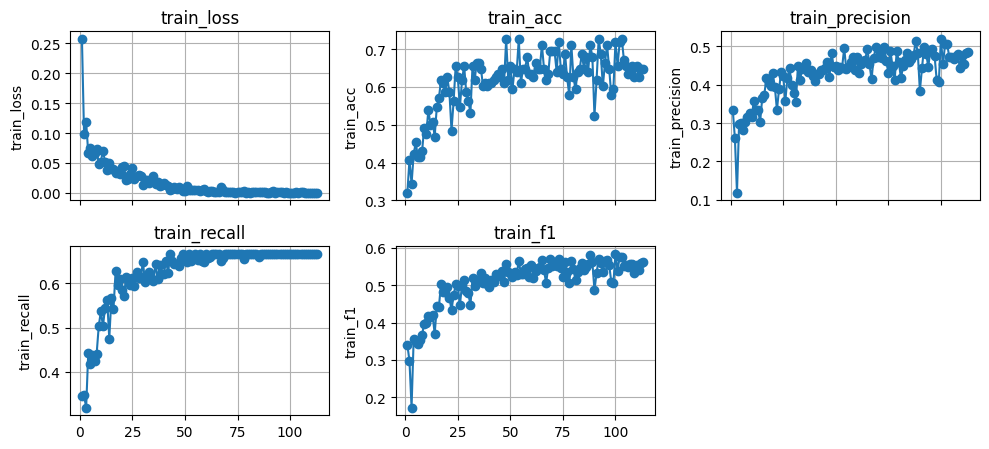

In [4]:
import json

with open(config.log_path + '/train_dict.json', 'r', encoding='utf-8') as file:
    train_dict = json.load(file)
with open(config.log_path + '/test_dict.json', 'r', encoding='utf-8') as file:
    test_dict = json.load(file)
import matplotlib.pyplot as plt

epochs = range(1, len(train_dict['train_loss']) + 1)
# 设置2行3列的子图布局，因为只有5个指标，所以最后一列会空出来
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True)
# Flatten axs to easily iterate over it in case of more than one column
axs = axs.flatten()
for i, (key, values) in enumerate(train_dict.items()):
    axs[i].plot(epochs, values, marker='o', label=key)
    axs[i].set_ylabel(key)
    axs[i].set_title(key)  # 添加标题以替代右侧的图例，避免重叠
    axs[i].grid(True)

# 隐藏空的子图
for ax in axs[len(train_dict):]:
    ax.axis('off')
axs[-1].set_xlabel('Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局，留出顶部空间给title或者避免紧凑
plt.show()

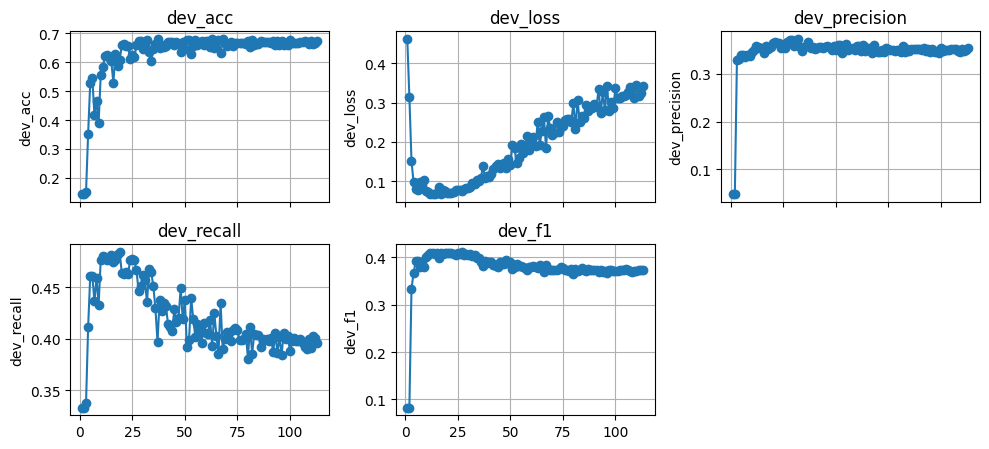

In [5]:
import matplotlib.pyplot as plt

epochs = range(1, len(test_dict['dev_loss']) + 1)
# 设置2行3列的子图布局，因为只有5个指标，所以最后一列会空出来
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True)
# Flatten axs to easily iterate over it in case of more than one column
axs = axs.flatten()
for i, (key, values) in enumerate(test_dict.items()):
    axs[i].plot(epochs, values, marker='o', label=key)
    axs[i].set_ylabel(key)
    axs[i].set_title(key)  # 添加标题以替代右侧的图例，避免重叠
    axs[i].grid(True)

# 隐藏空的子图
for ax in axs[len(test_dict):]:
    ax.axis('off')
axs[-1].set_xlabel('Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局，留出顶部空间给title或者避免紧凑
plt.show()